## Data Processing

In [1]:
# Import packages
import os
import sys
import warnings
import inspect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from scipy.interpolate import make_interp_spline
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA

# Regression analysis
import statsmodels.api as sm

# Set directories
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..')
data_dir = os.path.join(base_dir, 'data', 'processed')
factor_dir = os.path.join(base_dir, 'data', 'processed', 'factors')
raw_data_dir = os.path.join(base_dir, 'data', 'raw')
src_dir = os.path.join(base_dir, 'src')
graph_dir = os.path.join(base_dir, 'results', 'graphs')
sys.path.append(src_dir)

# Ignore future warning
warnings.simplefilter(action='ignore', category=FutureWarning)

In [216]:
cov_df = pd.read_csv(os.path.join(data_dir, 'covariates_weekly.csv'))
cov_df.head()

,Phase,Year_Week,R1-RF,R2-RF,R3-RF,CMA,CRD,EG,HML,IA,LIQ,ME,MOM,Mkt-RF,RMW,ROE,SMB
0,Recovery,1991-14,0.808722,0.888317,1.046018,-0.570730,1.150221,-0.5419,-0.869560,-0.2831,1.472018,1.9119,0.891933,0.513137,-0.032457,0.4557,1.521326
1,Recovery,1991-15,0.264305,0.625699,0.993622,0.621385,2.298820,0.2974,0.269460,0.7554,1.155684,-0.6018,0.530151,1.069284,-0.160184,1.1641,-0.205230
2,Recovery,1991-16,0.397411,0.907257,1.589490,0.369853,-0.318141,0.1628,1.181054,0.0403,0.726344,-0.6797,-2.540450,0.823179,0.438583,-0.9019,-0.383025
3,Recovery,1991-17,-0.461241,-0.400725,-0.402482,-0.120218,-1.594360,0.7819,0.109392,-0.2596,-1.943223,-0.6371,-0.758405,-1.507046,0.410131,0.1809,-0.043628
4,Recovery,1991-18,0.821113,1.524843,2.275011,0.149088,-0.747710,-0.9039,0.358368,0.0811,-1.789523,-0.6211,0.498412,0.284198,0.149900,0.3691,-0.427979


## PCA for Recovery

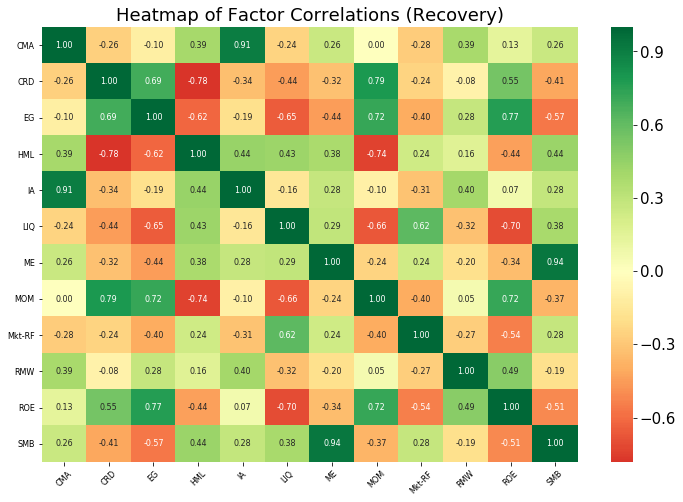

In [217]:
# check correlations for recovery
cur_phase = 'Recovery'
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
cur_phase_df = cov_df[cov_df['Phase'] == cur_phase]
factors_df = cur_phase_df.drop(
    columns = ['Phase', 'Year_Week', 'R1-RF', 'R2-RF', 'R3-RF']
)
# standardize
scaler = StandardScaler()
factors_df = pd.DataFrame(scaler.fit_transform(factors_df), columns=factors_df.columns)
corr_matrix = factors_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Factor Correlations (Recovery)')
plt.show()

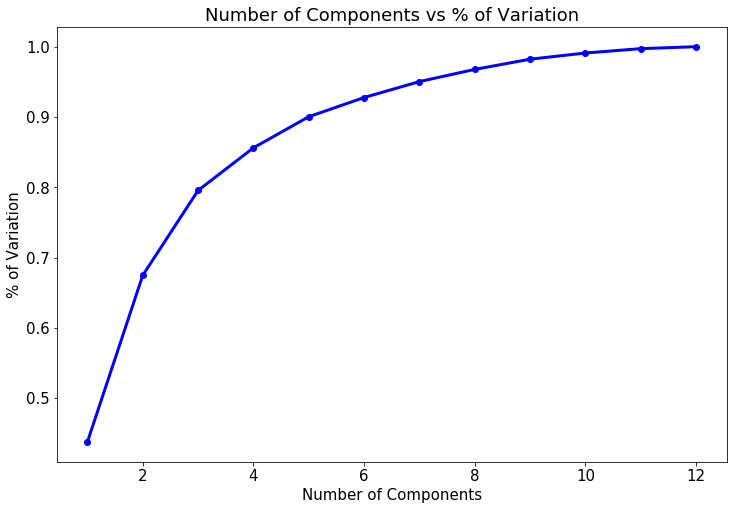

    Number of PCs  Total Variation %
0               1           0.437487
1               2           0.674585
2               3           0.795434
3               4           0.856067
4               5           0.900322
5               6           0.927648
6               7           0.950342
7               8           0.967701
8               9           0.982194
9              10           0.990998
10             11           0.997202
11             12           1.000000


In [218]:
var_sum = []
n_comps = [i + 1 for i in range(factors_df.shape[1])]
for i in n_comps:

    # PCA
    pca = PCA(n_components = i)
    pca.fit(factors_df)

    # Get the explained variance ratio
    var_sum.append(np.sum(pca.explained_variance_ratio_))
    
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
plt.plot(n_comps, var_sum, marker = 'o', color = "blue", linewidth = 3)
plt.xlabel("Number of Components")
plt.ylabel("% of Variation")
plt.title('Number of Components vs % of Variation')
plt.show()

print(pd.DataFrame({"Number of PCs": n_comps, "Total Variation %": var_sum}))

In [219]:
# Number of principal components to retain
# Note: originally 6 were chosen but we adjusted it back to 5 after regression results
n_components = 5 

# PCA
pca = PCA(n_components = n_components)
pca.fit(factors_df)

# Get the principal components
components = pca.components_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Transform original features into principal components
PC_df = pd.DataFrame(
    pca.transform(factors_df),
    columns = ['PC' + str(i + 1) for i in range(n_components)]
)

# Print results
print("Original features:")
print(factors_df)
print("\nPrincipal Components:")
print(components)
print("\nExplained Variance %:")
print(explained_variance_ratio)
print("\nTotal % of Variance Explained:")
print(np.sum(explained_variance_ratio))
print("\nTransformed features (after PCA):")
print(PC_df)

# Ignore future warning
warnings.simplefilter(action='ignore', category=DeprecationWarning)

Original features:
          CMA       CRD        EG       HML        IA       LIQ        ME  \
0   -0.562617  0.412595 -0.338778 -0.459358 -0.234627  0.288545  1.145205   
1    0.627869  0.835259  0.232001  0.064743  0.720060  0.173816 -0.696830   
2    0.376680 -0.127736  0.140464  0.484198  0.062673  0.018102 -0.753915   
3   -0.112720 -0.597361  0.561493 -0.008909 -0.213024 -0.950105 -0.722698   
4    0.156217 -0.285809 -0.584961  0.105653  0.100180 -0.894361 -0.710973   
..        ...       ...       ...       ...       ...       ...       ...   
170  0.475657 -0.839715 -1.926186  0.744651  0.653227  0.783698  0.658480   
171  0.343087  0.249505 -0.394815  0.390330  0.063868 -0.428795  0.111373   
172  0.664648  0.162412 -0.911461  0.773985 -0.185261  1.030243  0.893122   
173 -0.083190  0.025329  0.148489  0.174501  0.309136 -0.127841  1.233214   
174 -0.202506 -0.087581 -0.272539  0.050482 -0.285740 -0.429168 -0.835475   

          MOM    Mkt-RF       RMW       ROE       SMB  


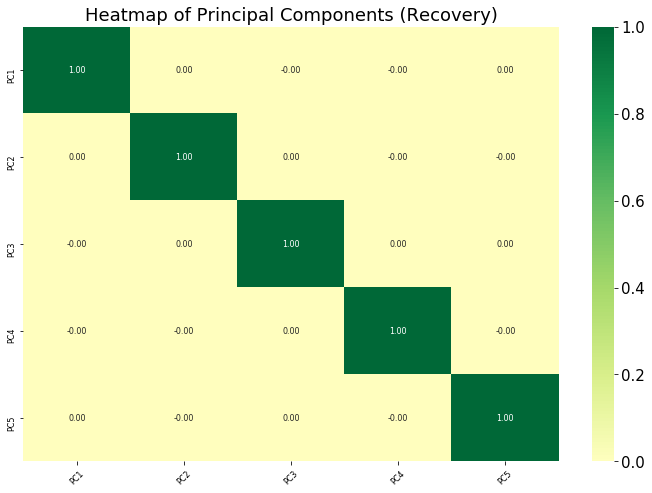

In [220]:
# heatmap of principal components
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
corr_matrix = PC_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Principal Components (Recovery)')
plt.show()

In [221]:
print("***** Regression on Low-Risk Portfolio (Recovery) *****")
print("\n")
x, y = PC_df, cur_phase_df['R1-RF'].values.reshape(-1, 1)
x = sm.add_constant(x)
r1_mdl = sm.OLS(y, x).fit()
print(r1_mdl.summary())
print("\n")

print("***** Regression on Medium-Risk Portfolio (Recovery) *****")
print("\n")
x, y = PC_df, cur_phase_df['R2-RF'].values.reshape(-1, 1)
x = sm.add_constant(x)
r2_mdl = sm.OLS(y, x).fit()
print(r2_mdl.summary())
print("\n")

print("***** Regression on High-Risk Portfolio (Recovery) *****")
print("\n")
x, y = PC_df, cur_phase_df['R3-RF'].values.reshape(-1, 1)
x = sm.add_constant(x)
r3_mdl = sm.OLS(y, x).fit()
print(r3_mdl.summary())

***** Regression on Low-Risk Portfolio (Recovery) *****


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.583
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     47.25
Date:                Thu, 07 Mar 2024   Prob (F-statistic):           2.17e-30
Time:                        23:56:53   Log-Likelihood:                -215.60
No. Observations:                 175   AIC:                             443.2
Df Residuals:                     169   BIC:                             462.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [222]:
# write csv
recovery_df = pd.concat([cur_phase_df, PC_df], axis = 1)
recovery_df.to_csv(os.path.join(data_dir, "recovery_factor_candidates.csv"), index = False)

## PCA for Expansion

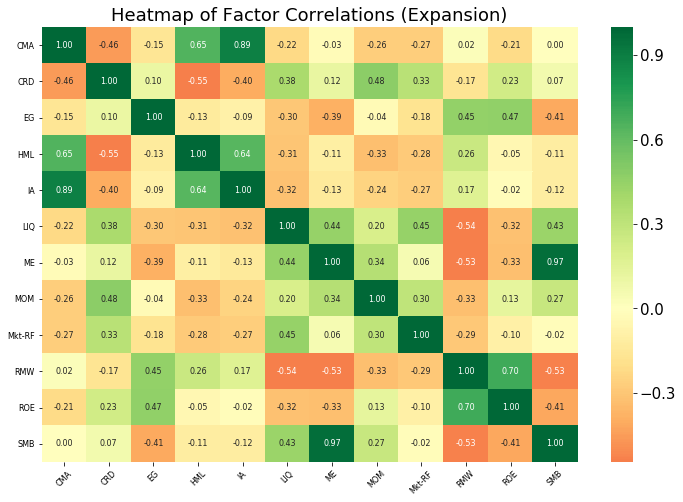

In [223]:
# check correlations for expansion
cur_phase = 'Expansion'
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
cur_phase_df = cov_df[cov_df['Phase'] == cur_phase].reset_index().drop(columns = ['index'])
factors_df = cur_phase_df.drop(
    columns = ['Phase', 'Year_Week', 'R1-RF', 'R2-RF', 'R3-RF']
)
# standardize
scaler = StandardScaler()
factors_df = pd.DataFrame(scaler.fit_transform(factors_df), columns=factors_df.columns)
corr_matrix = factors_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Factor Correlations (Expansion)')
plt.show()

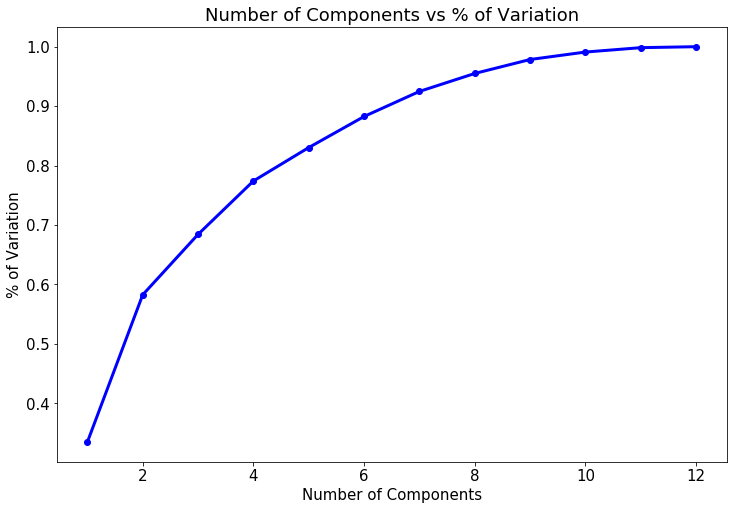

    Number of PCs  Total Variation %
0               1           0.334919
1               2           0.582633
2               3           0.684249
3               4           0.774044
4               5           0.830316
5               6           0.882565
6               7           0.924741
7               8           0.954954
8               9           0.978433
9              10           0.990992
10             11           0.998358
11             12           1.000000


In [224]:
var_sum = []
n_comps = [i + 1 for i in range(factors_df.shape[1])]
for i in n_comps:

    # PCA
    pca = PCA(n_components = i)
    pca.fit(factors_df)

    # Get the explained variance ratio
    var_sum.append(np.sum(pca.explained_variance_ratio_))
    
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
plt.plot(n_comps, var_sum, marker = 'o', color = "blue", linewidth = 3)
plt.xlabel("Number of Components")
plt.ylabel("% of Variation")
plt.title('Number of Components vs % of Variation')
plt.show()

print(pd.DataFrame({"Number of PCs": n_comps, "Total Variation %": var_sum}))

In [231]:
# Number of principal components to retain
n_components = 7

# PCA
pca = PCA(n_components = n_components)
pca.fit(factors_df)

# Get the principal components
components = pca.components_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Transform original features into principal components
PC_df = pd.DataFrame(
    pca.transform(factors_df),
    columns = ['PC' + str(i + 1) for i in range(n_components)]
)

# Print results
print("Original features:")
print(factors_df)
print("\nPrincipal Components:")
print(components)
print("\nExplained Variance %:")
print(explained_variance_ratio)
print("\nTotal % of Variance Explained:")
print(np.sum(explained_variance_ratio))
print("\nTransformed features (after PCA):")
print(PC_df)

# Ignore future warning
warnings.simplefilter(action='ignore', category=DeprecationWarning)

Original features:
          CMA       CRD        EG       HML        IA       LIQ        ME  \
0   -0.302718  0.721630 -1.069164 -0.077624  0.151807  0.613627  0.364161   
1    0.443003 -0.085718  0.111798  0.028345  0.477396 -1.312934 -0.023088   
2   -0.442271  1.690075  0.231876 -1.123044 -0.373573 -0.417751 -0.419699   
3   -0.337609  0.014323  0.465467 -0.466438 -0.490451 -0.414824 -0.440729   
4   -1.176896  2.408890 -0.603623 -2.066923 -0.549005 -0.408359 -0.181387   
..        ...       ...       ...       ...       ...       ...       ...   
594 -1.186827 -1.095739 -1.787236  0.969341 -0.395416  0.333036 -0.130397   
595  3.472283 -2.201634 -2.044565  4.936220  3.885048  0.202874  0.601682   
596  1.280350 -1.321331 -0.288717  1.928085  1.306980 -0.682298 -0.619481   
597 -0.892352  0.214986 -0.424704 -0.886425 -0.542257 -0.331869 -0.109871   
598 -0.557405  0.106488 -0.047802 -0.636369  0.193435  1.555019  0.961131   

          MOM    Mkt-RF       RMW       ROE       SMB  


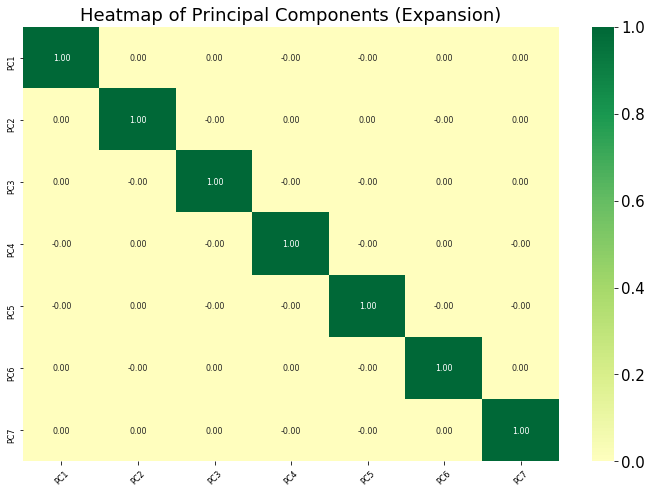

In [232]:
# heatmap of principal components
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
corr_matrix = PC_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Principal Components (Expansion)')
plt.show()

In [233]:
print("***** Regression on Low-Risk Portfolio (Expansion) *****")
print("\n")
x, y = PC_df, cur_phase_df['R1-RF']
x = sm.add_constant(x)
r1_mdl = sm.OLS(y, x).fit()
print(r1_mdl.summary())
print("\n")

print("***** Regression on Medium-Risk Portfolio (Expansion) *****")
print("\n")
x, y = PC_df, cur_phase_df['R2-RF']
x = sm.add_constant(x)
r2_mdl = sm.OLS(y, x).fit()
print(r2_mdl.summary())
print("\n")

print("***** Regression on High-Risk Portfolio (Expansion) *****")
print("\n")
x, y = PC_df, cur_phase_df['R3-RF']
x = sm.add_constant(x)
r3_mdl = sm.OLS(y, x).fit()
print(r3_mdl.summary())

***** Regression on Low-Risk Portfolio (Expansion) *****


                            OLS Regression Results                            
Dep. Variable:                  R1-RF   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     129.4
Date:                Thu, 07 Mar 2024   Prob (F-statistic):          7.46e-115
Time:                        23:59:18   Log-Likelihood:                -867.05
No. Observations:                 599   AIC:                             1750.
Df Residuals:                     591   BIC:                             1785.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------

In [234]:
# write csv
expansion_df = pd.concat([cur_phase_df, PC_df.reset_index().drop(columns = ['index'])], axis = 1)
expansion_df.to_csv(os.path.join(data_dir, "expansion_factor_candidates.csv"), index = False)

## PCA for Downturn

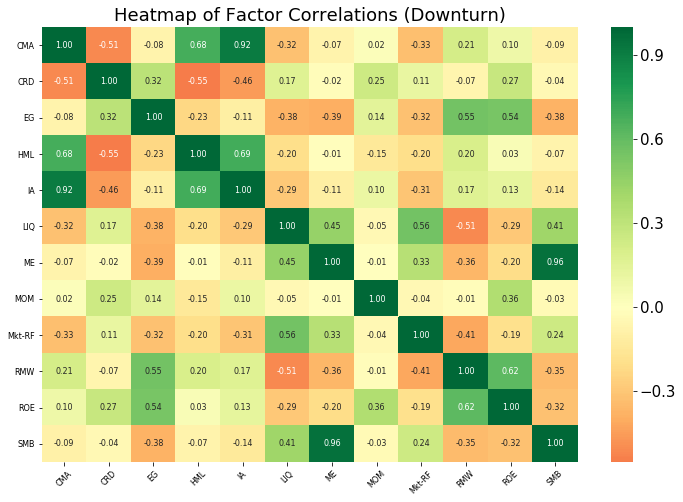

In [235]:
# check correlations for expansion
cur_phase = 'Downturn'
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
cur_phase_df = cov_df[cov_df['Phase'] == cur_phase].reset_index().drop(columns = ['index'])
factors_df = cur_phase_df.drop(
    columns = ['Phase', 'Year_Week', 'R1-RF', 'R2-RF', 'R3-RF']
)
# standardize
scaler = StandardScaler()
factors_df = pd.DataFrame(scaler.fit_transform(factors_df), columns=factors_df.columns)
corr_matrix = factors_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Factor Correlations (Downturn)')
plt.show()

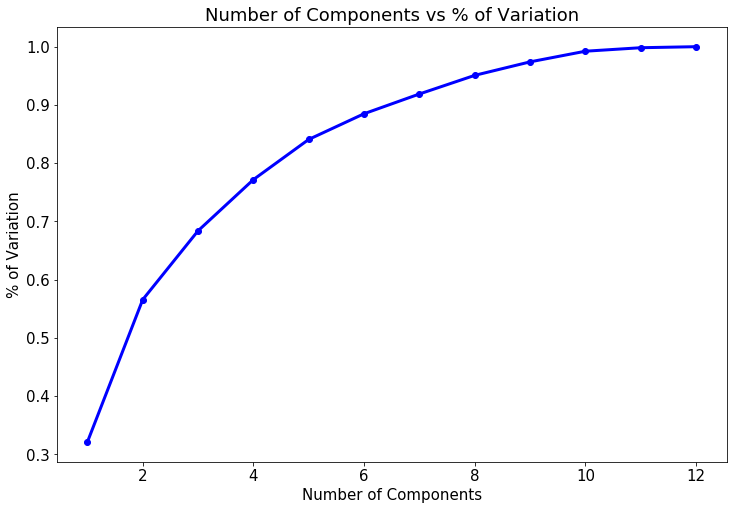

    Number of PCs  Total Variation %
0               1           0.320948
1               2           0.565521
2               3           0.683765
3               4           0.771707
4               5           0.840725
5               6           0.884847
6               7           0.918776
7               8           0.950770
8               9           0.973934
9              10           0.992234
10             11           0.998224
11             12           1.000000


In [236]:
var_sum = []
n_comps = [i + 1 for i in range(factors_df.shape[1])]
for i in n_comps:

    # PCA
    pca = PCA(n_components = i)
    pca.fit(factors_df)

    # Get the explained variance ratio
    var_sum.append(np.sum(pca.explained_variance_ratio_))
    
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
plt.plot(n_comps, var_sum, marker = 'o', color = "blue", linewidth = 3)
plt.xlabel("Number of Components")
plt.ylabel("% of Variation")
plt.title('Number of Components vs % of Variation')
plt.show()

print(pd.DataFrame({"Number of PCs": n_comps, "Total Variation %": var_sum}))

In [240]:
# Number of principal components to retain
# Note: originally 7 were chosen but we adjusted it back to 6 after regression results
n_components = 6

# PCA
pca = PCA(n_components = n_components)
pca.fit(factors_df)

# Get the principal components
components = pca.components_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Transform original features into principal components
PC_df = pd.DataFrame(
    pca.transform(factors_df),
    columns = ['PC' + str(i + 1) for i in range(n_components)]
)

# Print results
print("Original features:")
print(factors_df)
print("\nPrincipal Components:")
print(components)
print("\nExplained Variance %:")
print(explained_variance_ratio)
print("\nTotal % of Variance Explained:")
print(np.sum(explained_variance_ratio))
print("\nTransformed features (after PCA):")
print(PC_df)

# Ignore future warning
warnings.simplefilter(action='ignore', category=DeprecationWarning)

Original features:
          CMA       CRD        EG       HML        IA       LIQ        ME  \
0    0.524224  0.000260  0.410220  0.018648  0.528584 -0.288932 -0.279152   
1   -0.593716  0.306840  0.370080 -0.750948 -0.321286  0.050414 -0.595085   
2   -0.341562  0.116116  1.170984 -0.109326 -0.056311  0.802430  0.294643   
3   -0.396874  1.993948 -0.070932 -0.538789  0.015755  0.732936 -0.773140   
4   -0.887652  0.058921 -0.428197 -0.162492 -0.927085  0.274356  1.286151   
..        ...       ...       ...       ...       ...       ...       ...   
664 -0.327938  0.051543  0.724718 -0.272751 -0.831925  0.186921  0.822767   
665  1.328060  0.195944 -0.100669  0.622306  1.360238 -0.342930  0.707412   
666 -4.529482  2.195266  0.555123 -2.669345 -4.162224 -2.077187 -1.246882   
667 -4.173304  1.412510 -0.079338 -4.078427 -5.481423 -0.855505 -0.981722   
668  1.543069 -0.449815 -0.840838  1.659798  1.871275 -2.105617  0.822689   

          MOM    Mkt-RF       RMW       ROE       SMB  


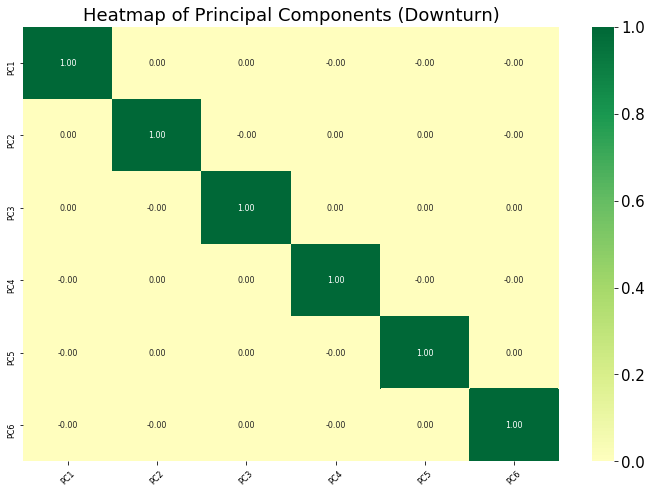

In [241]:
# heatmap of principal components
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
corr_matrix = PC_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Principal Components (Downturn)')
plt.show()

In [244]:
print("***** Regression on Low-Risk Portfolio (Downturn) *****")
print("\n")
x, y = PC_df, cur_phase_df['R1-RF']
x = sm.add_constant(x)
r1_mdl = sm.OLS(y, x).fit()
print(r1_mdl.summary())
print("\n")

print("***** Regression on Medium-Risk Portfolio (Downturn) *****")
print("\n")
x, y = PC_df, cur_phase_df['R2-RF']
x = sm.add_constant(x)
r2_mdl = sm.OLS(y, x).fit()
print(r2_mdl.summary())
print("\n")

print("***** Regression on High-Risk Portfolio (Downturn) *****")
print("\n")
x, y = PC_df, cur_phase_df['R3-RF']
x = sm.add_constant(x)
r3_mdl = sm.OLS(y, x).fit()
print(r3_mdl.summary())

***** Regression on Low-Risk Portfolio (Downturn) *****


                            OLS Regression Results                            
Dep. Variable:                  R1-RF   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     101.4
Date:                Fri, 08 Mar 2024   Prob (F-statistic):           2.60e-90
Time:                        00:01:15   Log-Likelihood:                -1068.9
No. Observations:                 669   AIC:                             2152.
Df Residuals:                     662   BIC:                             2183.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

In [245]:
# write csv
downturn_df = pd.concat([cur_phase_df, PC_df.reset_index().drop(columns = ['index'])], axis = 1)
downturn_df.to_csv(os.path.join(data_dir, "downturn_factor_candidates.csv"), index = False)

## PCA for Depression

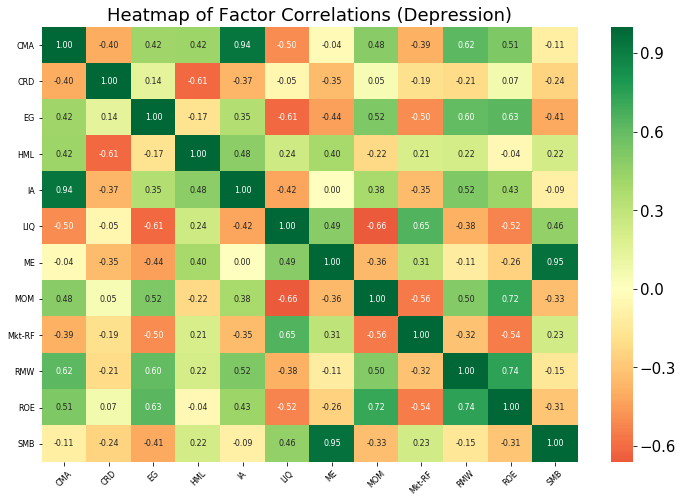

In [246]:
# check correlations for expansion
cur_phase = 'Depression'
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
cur_phase_df = cov_df[cov_df['Phase'] == cur_phase].reset_index().drop(columns = ['index'])
factors_df = cur_phase_df.drop(
    columns = ['Phase', 'Year_Week', 'R1-RF', 'R2-RF', 'R3-RF']
)
# standardize
scaler = StandardScaler()
factors_df = pd.DataFrame(scaler.fit_transform(factors_df), columns=factors_df.columns)
corr_matrix = factors_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Factor Correlations (Depression)')
plt.show()

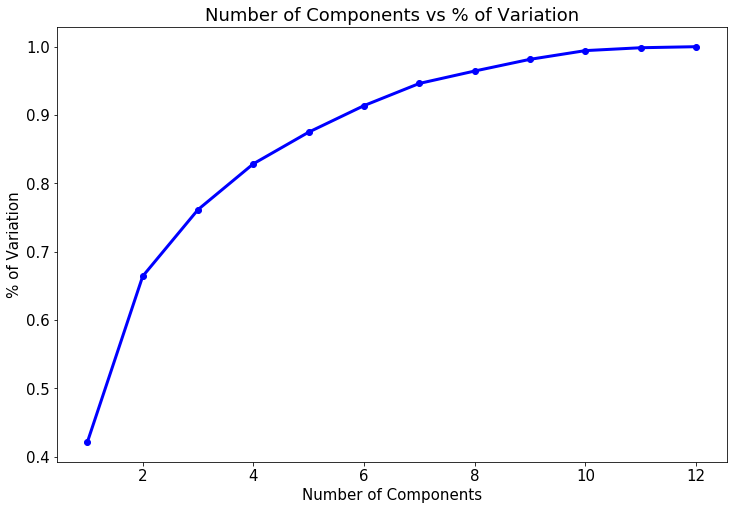

    Number of PCs  Total Variation %
0               1           0.421285
1               2           0.664012
2               3           0.761576
3               4           0.828595
4               5           0.874918
5               6           0.913775
6               7           0.946232
7               8           0.964400
8               9           0.981525
9              10           0.994260
10             11           0.998465
11             12           1.000000


In [247]:
var_sum = []
n_comps = [i + 1 for i in range(factors_df.shape[1])]
for i in n_comps:

    # PCA
    pca = PCA(n_components = i)
    pca.fit(factors_df)

    # Get the explained variance ratio
    var_sum.append(np.sum(pca.explained_variance_ratio_))
    
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
plt.plot(n_comps, var_sum, marker = 'o', color = "blue", linewidth = 3)
plt.xlabel("Number of Components")
plt.ylabel("% of Variation")
plt.title('Number of Components vs % of Variation')
plt.show()

print(pd.DataFrame({"Number of PCs": n_comps, "Total Variation %": var_sum}))

In [248]:
# Number of principal components to retain
n_components = 7

# PCA
pca = PCA(n_components = n_components)
pca.fit(factors_df)

# Get the principal components
components = pca.components_

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Transform original features into principal components
PC_df = pd.DataFrame(
    pca.transform(factors_df),
    columns = ['PC' + str(i + 1) for i in range(n_components)]
)

# Print results
print("Original features:")
print(factors_df)
print("\nPrincipal Components:")
print(components)
print("\nExplained Variance %:")
print(explained_variance_ratio)
print("\nTotal % of Variance Explained:")
print(np.sum(explained_variance_ratio))
print("\nTransformed features (after PCA):")
print(PC_df)

# Ignore future warning
warnings.simplefilter(action='ignore', category=DeprecationWarning)

Original features:
          CMA       CRD        EG       HML        IA       LIQ        ME  \
0    0.291198  0.708098  0.260019  0.707224  0.542508 -0.048855 -0.803104   
1   -1.157558  2.354629  0.374288 -0.833450 -0.436834  0.925622 -1.461095   
2    0.203605 -0.439013  0.421861 -0.089454 -0.055246 -0.053587  0.501459   
3    0.431328  0.478430  0.011182  0.229914  0.443598  0.022198 -1.430330   
4   -1.222673  0.557940 -0.720204 -0.116121 -0.765337  0.067218 -0.255007   
..        ...       ...       ...       ...       ...       ...       ...   
283 -0.438374 -0.667895 -1.332931 -0.034818 -0.257203  0.518069  0.128281   
284  1.340946 -0.750069  0.202885  0.423620  1.114499 -0.550680 -1.507087   
285 -0.188292  0.405654 -0.828046  0.131206 -0.321217  0.269536  0.733977   
286  0.294284  0.316404 -0.635873 -0.520309  0.616749 -0.223846  0.180264   
287  0.646278 -0.182558 -0.053241  0.029870  0.798643  0.022861 -0.751683   

          MOM    Mkt-RF       RMW       ROE       SMB  


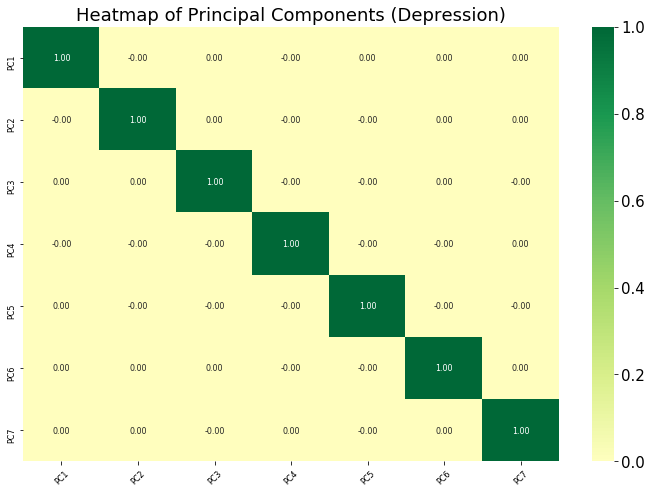

In [249]:
# heatmap of principal components
plt.figure(figsize = (12, 8))
plt.rcParams.update({'font.size': 15})
corr_matrix = PC_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlGn', center=0, fmt='.2f', annot_kws={'fontsize':8})
plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Heatmap of Principal Components (Depression)')
plt.show()

In [250]:
print("***** Regression on Low-Risk Portfolio (Depression) *****")
print("\n")
x, y = PC_df, cur_phase_df['R1-RF']
x = sm.add_constant(x)
r1_mdl = sm.OLS(y, x).fit()
print(r1_mdl.summary())
print("\n")

print("***** Regression on Medium-Risk Portfolio (Depression) *****")
print("\n")
x, y = PC_df, cur_phase_df['R2-RF']
x = sm.add_constant(x)
r2_mdl = sm.OLS(y, x).fit()
print(r2_mdl.summary())
print("\n")

print("***** Regression on High-Risk Portfolio (Depression) *****")
print("\n")
x, y = PC_df, cur_phase_df['R3-RF']
x = sm.add_constant(x)
r3_mdl = sm.OLS(y, x).fit()
print(r3_mdl.summary())

***** Regression on Low-Risk Portfolio (Depression) *****


                            OLS Regression Results                            
Dep. Variable:                  R1-RF   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.296
Date:                Fri, 08 Mar 2024   Prob (F-statistic):              0.252
Time:                        00:01:46   Log-Likelihood:                -1427.7
No. Observations:                 288   AIC:                             2871.
Df Residuals:                     280   BIC:                             2901.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

In [251]:
# write csv
depression_df = pd.concat([cur_phase_df, PC_df.reset_index().drop(columns = ['index'])], axis = 1)
depression_df.to_csv(os.path.join(data_dir, "depression_factor_candidates.csv"), index = False)